# SVB evaluation on ASL 

Evaluation of hybrid inference (cortical surface, volumetric WM and subcortical ROIs) using SVB and the aslrest model. 

## Purpose 

Evaluation of how hybrid SVB performs, and comparison to volumetric BASIL with PVEc followed by surface projection. 

## ASL data 

ASL data is simulated using SVB's aslrest model with 6 PLDs of 8 repeats each (1.8s pCASL labelling).

- Cortex: a sinusoidal CBF map of value 60±20 units. ATT is a constant 1.1s everywhere, which is deliberately different to the default 1.3s assumed by SVB and BASIL 

- WM: a constant CBF value of 20 units and ATT of 1.8s, again different to the default assumption of 1.6s. 

- ROIs: for the 7 ROIs segmented by FSL FIRST, we assume CBF values of [45, 50, ..., 75]. ATT is constant 1.1s for all ROIs. Note that ROIs are assumed to be 'homogenous GM' identical to cortical GM by both methods (which sets the partition coefficient and fcalib etc). 

## Inference methods 

- SVB: hybrid inference, which implies PVEc and surface projection as part of the process. An intial pre-fit on CBF only is performed before the main fit. A spatial prior is used on both CBF and ATT. 

- BASIL: a call to oxasl using default settings and volumetric PV maps generated from Toblerone. A spatial prior is used on CBF, whereas a distributional prior is used on ATT (1.3s for GM and 1.6s for ATT). This means the PV information used by both methods is the same. Finally the PVEc output is surface projected using Toblerone. 

The use of non-standard ATT (1.1s in GM, 1.8s in WM) is to try and demonstrate the robustness of SVB in this parameter, via the use of a spatial prior instead of a distributional prior. 

## Experiment parameters 

- Method. SVB hybrid or BASIL PVEc + projection 

- SNR. Typical SNR has been calculated using Mezue's PCASL multi-PLD reproducibility dataset from 2014. We simulate data with SNR values $2^n$ around this level, in the range of [-1, 1] (ie, half SNR to double SNR). 

- Voxel size. All data is simulated at 1mm isotropic resolution and then resampled by summation over aligned voxel grids to sizes [2,3,4,5] mm iso. This means there is no interpolation artefact and data at any resolution conveys the same underlying information. 

In [47]:
%load_ext autoreload 
%autoreload 2 

import sys 
sys.path.insert(1, '/Users/thomaskirk/modules/svb_module')
sys.path.insert(1, '/Users/thomaskirk/modules/svb_models_asl')

import numpy as np
import toblerone as tob 

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import pyvista as pv 
import pandas as pd 
import nibabel as nib 
from scipy import stats
from multiprocessing import Pool
import os.path as op
import copy 
import helpers 
from helpers import WM_CBF, GM_ATT, WM_ATT, TIME_SCALE, ROI_NAMES
import sklearn.metrics

GM_ATT = GM_ATT / TIME_SCALE
WM_ATT = WM_ATT / TIME_SCALE 

niiload = lambda p: np.squeeze(nib.load(p).get_fdata().flatten())
giiload = lambda p: np.squeeze(nib.load(p).darrays[0].data)

vox_sizes = [2,3,4,5]
SNR_RATIO = [-1, -0.5, 0, 0.5, 1]
RPT = 8
SPH = tob.Surface('sph_32k.surf.gii')
ctx_cbf = helpers.make_activation(SPH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
projectors = {}
for v in vox_sizes: 
    proj_path = f'brain_proj_{v}.h5'
    projectors[v] = tob.Projector.load(proj_path)
    
thick_mask = projectors[2].cortex_thickness() > 0.2
ctx_cbf = ctx_cbf[thick_mask]

## Ground truth cortical CBF maps 

Displayed on the 32k sphere (left) and pial surface (right). 

In [49]:
def unmask(x): 
    y = np.zeros(thick_mask.size)
    y[thick_mask] = x 
    return y 

pl = pv.Plotter(shape=(1, 2), window_size=(800,400))
faces = 3 * np.ones((SPH.tris.shape[0], 4), dtype=int)
faces[:,1:] = SPH.tris 
m1 = pv.PolyData(SPH.points, faces=faces)
m2 = pv.PolyData(projectors[2]['LPS'].points, faces=faces)


for idx,snr in enumerate(SNR_RATIO): 

    pl.subplot(0, 0)
    m = copy.deepcopy(m1).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=unmask(ctx_cbf), clim=[40,80])
    pl.add_title('Inflated sphere')

    pl.subplot(0, 1)
    m = copy.deepcopy(m2).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=unmask(ctx_cbf), clim=[40,80])
    pl.add_title('Pial surface')

pl.show(jupyter_backend='panel')

BokehModel(combine_events=True, render_bundle={'docs_json': {'f49ce845-768d-41b3-8e35-17ebab55f590': {'defs': …

In [50]:
df = []
for v in vox_sizes: 

    proj = projectors[v]

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:

        odir = f"brain_test/svb_vox-{v}_snr-{snr}_rpt-{RPT}"
        gm_cbf = giiload(op.join(odir, 'step2/mean_ftiss_L_cortex.func.gii'))
        wm_cbf = niiload(op.join(odir, 'step2/mean_ftiss_Volume_WM.nii.gz'))
        gm_att = giiload(op.join(odir, 'step2/mean_delttiss_L_cortex.func.gii')) / TIME_SCALE
        wm_att = niiload(op.join(odir, 'step2/mean_delttiss_Volume_WM.nii.gz')) / TIME_SCALE

        wm_mask = wm_cbf.astype(bool)

        df.append({ 'method': 'svb', 'vox': v, 'snr': snr, 'gm_cbf': gm_cbf[thick_mask], 
                    'wm_cbf': wm_cbf[wm_mask], 'gm_att': gm_att[thick_mask], 'wm_att': wm_att[wm_mask] })

        odir = f"brain_test/basil_vox-{v}_snr-{snr}_rpt-{RPT}"
        gm_cbf_v = niiload(op.join(odir, 'output_pvcorr/native/perfusion.nii.gz'))
        gm_cbf = proj.vol2surf(gm_cbf_v.flatten(), edge_scale=False)    
        wm_cbf = niiload(op.join(odir, 'output_pvcorr/native/perfusion_wm.nii.gz'))
        gm_att_v = niiload(op.join(odir, 'output_pvcorr/native/arrival.nii.gz'))
        gm_att = proj.vol2surf(gm_att_v.flatten(), edge_scale=False)    
        wm_att = niiload(op.join(odir, 'output_pvcorr/native/arrival_wm.nii.gz'))

        df.append({ 'method': 'basil', 'vox': v, 'snr': snr, 'vox': v, 'gm_cbf': gm_cbf[thick_mask], 
                    'wm_cbf': wm_cbf[wm_mask], 'gm_att': gm_att[thick_mask], 'wm_att': wm_att[wm_mask] })
                    

df = pd.DataFrame(df).set_index(['method', 'vox', 'snr']).sort_index(level='method')

## Analysis 1: visual inspection of cortical CBF maps at 3mm iso. 

Lots to see here. I think for pretty much all SNR and voxel sizes, SVB's map preserves more spatial detail than BASILs. For low SNR, BASIL displays some convergence issues at small voxel sizes (large positive bias) or excessively smooth maps. At large voxel sizes, it is hard to discern much detail in BASIL's map, presumably due to PVE. 

What is interesting is how substantially the two methods differ on very challenging data (large voxels or low SNR). SVB will return very noisy maps, for the sake of preserving contrast between areas of high and low perfusion. BASIL prefers to smooth instead, giving a much more uniform map. 

In [51]:
pl = pv.Plotter(shape=(2*len(vox_sizes), len(SNR_RATIO) + 1), window_size=(1200,1200))
faces = 3 * np.ones((SPH.tris.shape[0], 4), dtype=int)
faces[:,1:] = SPH.tris 
mesh = pv.PolyData(SPH.points, faces=faces)

for vidx,v in enumerate(vox_sizes): 
    for idx,snr in enumerate(SNR_RATIO): 

        svb, basil = df.xs((v, snr), level=['vox','snr']).gm_cbf.loc[['svb', 'basil']]
        basil = unmask(basil)
        svb = unmask(svb)

        pl.subplot(2*vidx, idx)
        m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
        actor = pl.add_mesh(m, scalars=svb, clim=[40,80])
        pl.add_title(f'SVB v = {v}, SNR = {snr}')

        pl.subplot(2*vidx+1, idx)
        m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
        actor = pl.add_mesh(m, scalars=basil, clim=[40,80])
        pl.add_title(f'SVB v = {v}, SNR = {snr}')

    for x in [0,1]: 
        pl.subplot(2*vidx+x, len(SNR_RATIO))
        m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
        actor = pl.add_mesh(m, scalars=unmask(ctx_cbf), clim=[40,80])
        pl.add_title(f'Truth')

pl.show(jupyter_backend='panel')

BokehModel(combine_events=True, render_bundle={'docs_json': {'ed148230-23ae-4e48-96a1-017584387222': {'defs': …

## Analysis 2.1: histograms of cortical CBF. 

These help illustrates the presence of bias and/or excessive smoothing as noise increases. 

At low SNR, BASIL shows positive bias, and also the individual distributions for each voxel size differ markedly, showing the bias is not constant. 

SVB shows a smaller level of bias (the peak of the distribution is closer to ground truth peak) for all SNR. SVB also shows much better consistency between voxel sizes for all SNR. As SNR decreases, the distribution returned by SVB is however increasingly wide (greater variance), whereas BASIL tends in the opposite direction of smaller variance. This means that the extremes of the distribution lie within the original ground truth extremes. Qualitatively, this corresponds to increasingly smooth maps devoid of detail, as was seen on the visual inspection. 

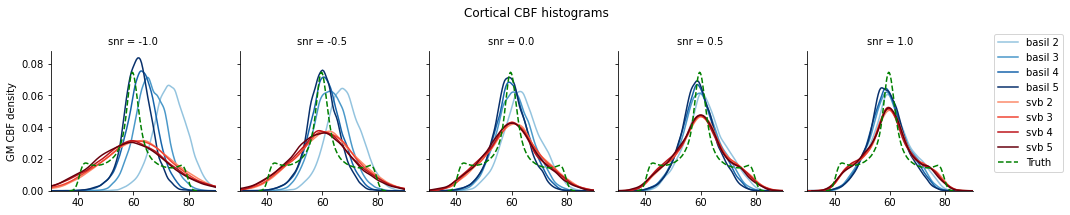

In [52]:
g = sns.FacetGrid(df['gm_cbf'].reset_index(), col='snr')

reds = get_cmap('Reds')
blues = get_cmap('Blues')

def mapper(data, color): 
    for tup in data.itertuples(): 
        c = reds(tup.vox/5) if tup.method == 'svb' else blues(tup.vox/5)
        ax = sns.kdeplot(tup.gm_cbf, color=c, label=f'{tup.method} {tup.vox}')
    ax.set_ylabel('GM CBF density')

g.map_dataframe(mapper)
for ax in g.axes.flat: 
    sns.kdeplot(ctx_cbf, color='g', label='Truth', ax=ax, linestyle='dashed')
    ax.set_xlim(30,90)
ax.legend(bbox_to_anchor=(1.1,0.1))

g.fig.suptitle('Cortical CBF histograms')
g.tight_layout()

## Analysis 2.2: differences in estimated cortical CBF

The previous analysis showed that BASIL and SVB differ markedly at the extremes of the distribution. SVB will tolerate vertices with very high or low CBF values whereas BASIL will prefer to smooth them over, reducing the spread of the final distribution. 

To better illustrate this, we can perform a vertex-wise regression of (SVB CBF - BASIL CBF) against (ground truth CBF). This shows that for vertices with low ground truth CBF, BASIL estimates a higher CBF than SVB and thus the difference is negative. For vertices with high ground truth CBF, SVB estimates a higher CBF than BASIL and the difference is positive. This linear relationship holds across all voxel sizes and SNRs, though becomes less strong at high SNR and small voxel size, which is as expected (better data leads to better estimates for both methods). 

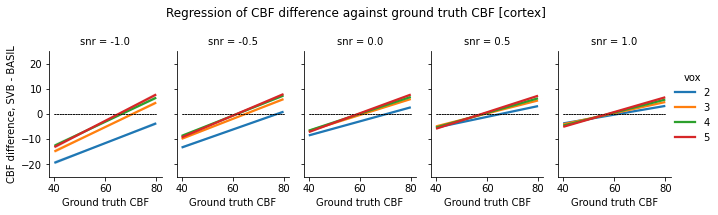

In [53]:
diffs = (df.xs('svb') - df.xs('basil'))['gm_cbf']
diffs = diffs.reset_index()

g = sns.FacetGrid(diffs, hue='vox', col='snr')

def mapper(data, color=None, label=None): 
    x = data.values[0]
    ax = sns.regplot(y=x[::10], x=ctx_cbf[::10], color=color, label=label, scatter=False)
    ax.plot([40,80], [0,0], 'k--', linewidth=0.5)

g.map(mapper, 'gm_cbf')
g.set(ylim=(-25,25))
g.add_legend()
g.set_ylabels('CBF difference, SVB - BASIL')
g.set_xlabels("Ground truth CBF")

g.fig.suptitle("Regression of CBF difference against ground truth CBF [cortex]")
g.fig.set_size_inches(10,3)
g.tight_layout()

## Analysis 3: metrics of accuracy for cortical CBF

Which method better recovers ground truth CBF? We compare a) SSD in CBF, b) SSD in the Z-score of CBF (which conveys the relative difference between areas of high and low perfusion) and c) the K-L divergence between the estimated distribution and the ground truth distribution. 

On all metrics, SVB performs worse at low SNR and better at high SNR. The crossover point is generally between SNR = -0.5 or SNR = 0 (ie, typical SNR or a bit worse than typical). A further important feature is that SVB displays excellent consistency between voxel sizes for all SNR, which is not true of BASIL. 

SSD in CBF is an imperfect metric here because at low SNR, SVB returns increasingly extreme CBF values that preserve the overall spatial distribution. BASIL returns values that tend towards the mean (higher smoothing). At some point, the former will return a higher SSD than the latter, even though the latter has removed much spatial detail. Hence the SSD in Z-score CBF attempts to account for this behaviour, and SVB performs better on this. 

What is very much lacking is a metric that incorporates spatial information. All the aforementioned metrics operate on a vertex-wise basis and ignore neighbourhood information. I've tried quite a few different ideas (including threshold-free cluster enhancement [TFCE] as proposed by Nichols and Smith) but none so far have yielded a meaningful comparison. But, I'd argue the visual inspection demonstrates that SVB "looks better" pretty much all of the time - how can we convey this quantitatively?

In [54]:
cbf_ssd = df.gm_cbf.apply(lambda c: ((c - ctx_cbf) ** 2).sum())
cbf_kl = df.gm_cbf.apply(lambda c: stats.entropy(pk=c, qk=ctx_cbf))
cortex_zscore = df.gm_cbf.apply(stats.zscore)
true_zscore = stats.zscore(ctx_cbf)
zscore_ssd = cortex_zscore.apply(lambda z: ((z - true_zscore) ** 2).sum())

scores = pd.concat({'cbf_ssd': cbf_ssd, 'z_ssd': zscore_ssd, 'kl_div': cbf_kl}, axis=1)
scores = scores.melt(ignore_index=False, var_name='Metric').reset_index()

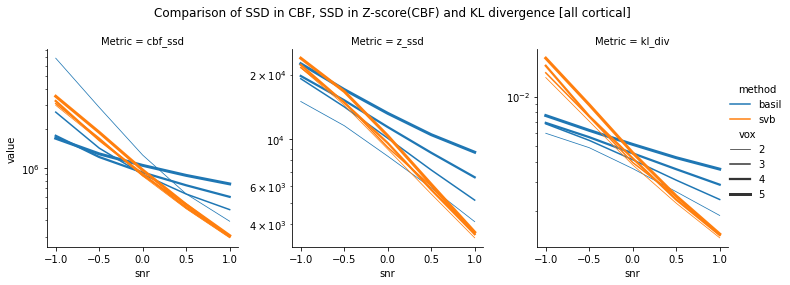

In [55]:
g = sns.relplot(data=scores, hue='method', col='Metric', y='value', x='snr', 
                size='vox', kind='line', facet_kws={'sharey': False})

for ax in g.axes.flat: ax.set_yscale('log')
g.fig.suptitle('Comparison of SSD in CBF, SSD in Z-score(CBF) and KL divergence [all cortical]')
g.fig.set_size_inches(11,4)
g.tight_layout()

## Analysis 4: ROC curves for hyper/hypo perfusion on the cortex

How well can each method pick up areas of high and low perfusion on the cortical surface? We use binary thresholding to pick out areas of high/low perfusion and compare them to ground truth. We can then calculate AUROC for each method. 

ROC requires setting a threshold value, eg ±10 from the mean. In the below analysis I've used thresholds of ±5 to ±15 in increments of 1. For hyper perfusion this means the threshold is set at 65, 66, ... 75, where the ground truth data lies in the range 60 ± 20. At each threshold, we calculate AUROC and plot that. 

SVB gives a higher AUROC than BASIL for all SNR and all voxel sizes. Once again SVB demonstrates much better consistency between voxel sizes whereas BASIL does not, particularly at low SNR. 

In [56]:
aurocs = [] 

for method, vox, snr in df.index: 
    for t in np.arange(5, 16, 1): 
        x = df.loc[method, vox, snr]['gm_cbf']

        # high
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=ctx_cbf > (60+t), y_score=x > (60+t))
        r1 = sklearn.metrics.auc(fpr, tpr)

        # low
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=ctx_cbf < (60-t), y_score=x < (60-t))
        r2 = sklearn.metrics.auc(fpr, tpr)

        r = (r1 + r2) / 2 
        aurocs.append({'method': method, 'vox': vox, 'snr': snr, 'auroc': r, 'thr': t})

aurocs = pd.DataFrame(aurocs)

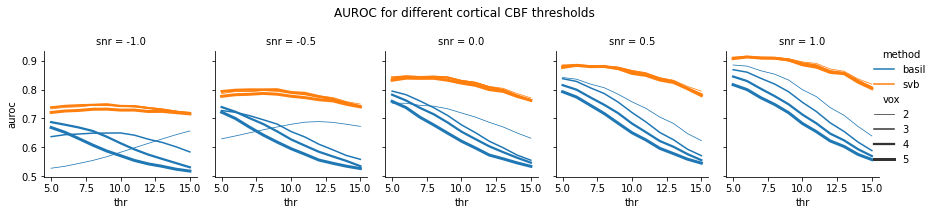

In [57]:
blues = sns.color_palette('Blues')
reds = sns.color_palette('Reds')
g = sns.relplot(data=aurocs, hue='method', x='thr', y='auroc', col='snr', kind='line', size='vox')
g.fig.suptitle("AUROC for different cortical CBF thresholds")
g.fig.set_size_inches(13,3)
g.tight_layout()

## Analysis 5: scatter plot comparison for areas of hyper/hypo perfusion on the cortex 

For each area of hyper/hypo perfusion on the cortex, calculate the mean CBF estimated by each method in that area and do a scatter plot comparison.

For all voxel sizes and all SNRs except (vox = 2 and SNR = -1, -0.5), SVB's estimates of hyper perfusion are consistently higher than BASIL, and vice-versa for hypo-perfusion. Almost all these comparisons meet a 1% significance threshold on a paired t-test. This is exactly as would be expected from the histograms: CBF is better at picking out regions of perfusion abnormality, both high and low, whereas BASIL is doing more smoothing. 

At 2mm voxel size and low SNR, BASIL struggles to converge (see the earlier histogram plots), which explains why the scatter plot looks very different to the others - its not a 'clean' comparison. 

In [58]:
adj = SPH.adjacency_matrix()
adj = adj[thick_mask,:]
adj = adj[:,thick_mask]

def grow_regions(binary_mask):
    regions = [ ]
    thick_mask_inds = np.flatnonzero(thick_mask)
    for idx in np.flatnonzero(binary_mask):
        if any([ idx in r for r in regions ]): 
            continue 
        region = set([idx])
        old = copy.deepcopy(region)
        done = False 
        while not done: 
            for o in copy.deepcopy(old): 
                new = set([i for i in adj[o,:].indices if binary_mask[i]])
                old = old | new 
            done = (region == old) 
            region = copy.deepcopy(old)
        regions.append(list(region))
    return [ r for r in regions if np.in1d(r, thick_mask_inds).all() ] 

hyper = grow_regions((ctx_cbf > 75))
hypo = grow_regions((ctx_cbf < 45))

rois = [] 
for snr in SNR_RATIO:
    for method in ['svb','basil']: 
        for v in vox_sizes: 
            cbf = df.loc[method,v,snr]['gm_cbf']
            for idx,r in enumerate(hyper): 
                rois.append({ 'method': method, 'vox': v, 'snr': snr, 'type': 'hyper', 'roi': idx, 'mean_cbf': cbf[r].mean() })
            for idx,r in enumerate(hypo): 
                rois.append({ 'method': method, 'vox': v, 'snr': snr, 'type': 'hypo', 'roi': idx, 'mean_cbf': cbf[r].mean() })

rois = pd.DataFrame(rois)
rois = rois.set_index(['method','vox','snr','type','roi'])

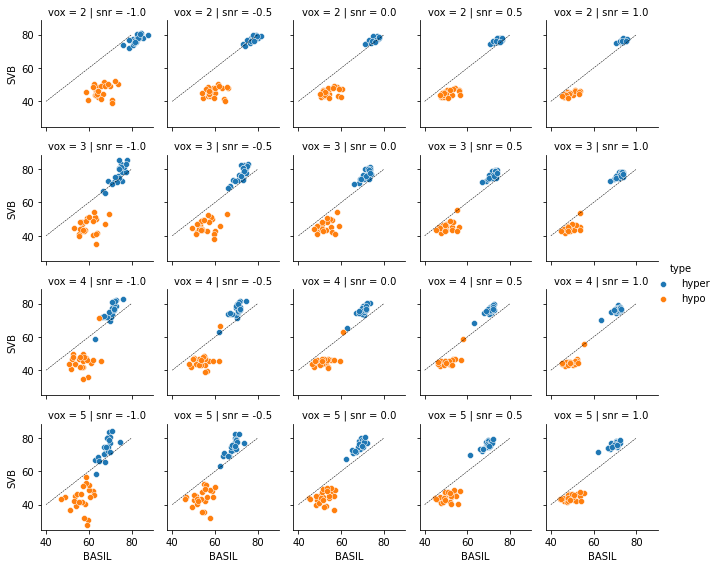

In [59]:
g = sns.FacetGrid(rois.unstack('method').reset_index(), col='snr', row='vox', hue='type')
g.map(sns.scatterplot, 'mean_cbf')
g.add_legend()
g.set_xlabels('BASIL')
g.set_ylabels('SVB')
for ax in g.axes.flat: 
    ax.plot([40,80], [40,80], 'k--', linewidth=0.5)

g.fig.set_size_inches(10,8)
g.tight_layout()

## Analysis 6: GM ATT histograms 

Ground truth ATT here is a constant value of 1.1s. 

SVB is returning a wide spread of values but the mean value is broadly in the right place for all SNR and voxel sizes. BASIL shows a positive bias for small voxel sizes and low SNR. At all SNR and voxel sizes, the variance of SVB's estimates looks to be tighter than BASILs. 

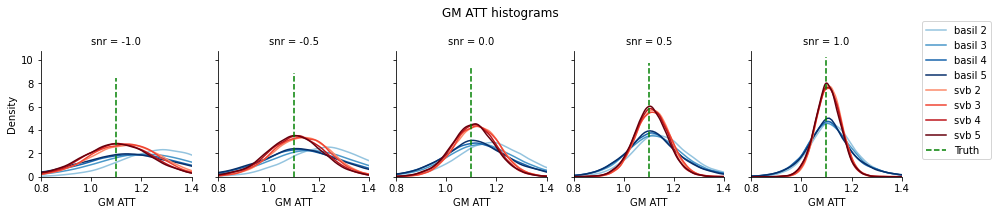

In [60]:
g = sns.FacetGrid(df['gm_att'].reset_index(), col='snr', hue='method')

reds = get_cmap('Reds')
blues = get_cmap('Blues')

def mapper(data, color, label): 
    for tup in data.itertuples(): 
        c = reds(tup.vox/5) if tup.method == 'svb' else blues(tup.vox/5)
        ax = sns.kdeplot(tup.gm_att, color=c, label=f'{tup.method} {tup.vox}')
    ax.set_ylabel('Density')

g.map_dataframe(mapper)
for ax in g.axes.flat: 
    lim = ax.get_ylim()[1]
    ax.plot([GM_ATT, GM_ATT], [0, lim], 'g--', label='Truth')
    ax.set_xlim([GM_ATT - 0.3, GM_ATT + 0.3])
    
ax.legend(bbox_to_anchor=(1.1,0.1))
g.fig.suptitle('GM ATT histograms')
g.set_xlabels('GM ATT')
g.fig.set_size_inches(14,3)
g.tight_layout()

## Analysis 7: WM CBF histograms 

Estimating WM CBF is much more challenging due to lower SNR than GM. This is especially the case for these simulations where WM ATT has been increased to 1.8s which means more signal decay. Ground truth CBF here is a constant value of 20. 

This is a tricky comparison. BASIL clearly displays high bias at low SNR, and inconsistency between voxel sizes. SVB tends to be slightly negatively biased, but this does seem to be consistent across SNR. The distribution is markedly wider for small voxel sizes (which have lower effective SNR). In general, the tradeoff here seems to be between the large variance of SVB's estimates, or the larger bias of BASILs. The next analysis also sheds some more light on this. 

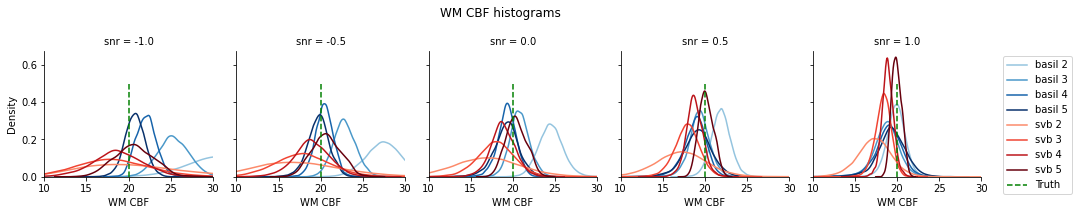

In [61]:
g = sns.FacetGrid(df['wm_cbf'].reset_index(), col='snr', hue='method')

reds = get_cmap('Reds')
blues = get_cmap('Blues')

def mapper(data, color, label): 
    for tup in data.itertuples(): 
        c = reds(tup.vox/5) if tup.method == 'svb' else blues(tup.vox/5)
        ax = sns.kdeplot(tup.wm_cbf, color=c, label=f'{tup.method} {tup.vox}')
    ax.set_xlim(10,30)
    ax.set_ylabel('Density')

g.map_dataframe(mapper)
for ax in g.axes.flat: 
    ax.plot([20,20], [0, 0.5], 'g--', label='Truth')
ax.legend(bbox_to_anchor=(1.1,1))

g.fig.suptitle('WM CBF histograms')
g.set_xlabels('WM CBF')
g.fig.set_size_inches(14,3)
g.tight_layout()

## Analysis 8: WM ATT histograms 

Ground truth ATT here is a constant value of 1.8s. 

Recalling that BASIL is using a distributional prior on WM ATT, whereas SVB uses a spatial prior, the *much* larger variance in BASIL's estimates makes sense here. I think BASIL has prioritised smoothing on the WM CBF map (tighter variance seen on the above histograms) at the expense of letting WM ATT vary enormously. Can we say WM ATT has become the 'free parameter' that is modified in order to obtain a tight distribution on WM CBF?

In all comparisons, SVB's WM ATT shows lower bias and tighter variance than BASIL's, though its by no means perfect. 

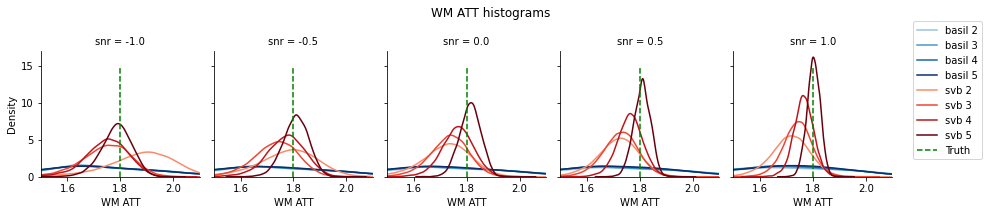

In [62]:
g = sns.FacetGrid(df['wm_att'].reset_index(), col='snr', hue='method', sharey=True)

reds = get_cmap('Reds')
blues = get_cmap('Blues')

def mapper(data, color, label): 
    for tup in data.itertuples(): 
        c = reds(tup.vox/5) if tup.method == 'svb' else blues(tup.vox/5)
        ax = sns.kdeplot(tup.wm_att, color=c, label=f'{tup.method} {tup.vox}')
    ax.set_ylabel('Density')

g.map_dataframe(mapper)
for ax in g.axes.flat: 
    ax.plot([WM_ATT, WM_ATT], [0, 15], 'g--', label='Truth')
    ax.set_xlim([WM_ATT - 0.3, WM_ATT + 0.3])
ax.legend(bbox_to_anchor=(1.1,0.1))

g.set_xlabels('WM ATT')
g.fig.suptitle('WM ATT histograms')
g.fig.set_size_inches(14,3)
g.tight_layout()

## Analysis 9: efficacy of volumetric PVEc

How effective is PVEc? We can only do this analysis in the WM because it is inferred voxel-wise; it doesn't make sense to refer to PVEc in the ROIs or cortex because they are not voxel structures. 

The metric of interest is the regression coefficient between CBF and WM PV. Prior to PVEc, this should be negative because increasing WM PV leads to decreasing CBF (because GM is displaced). After PVEc, there should be a weaker regression coefficient between the two because PVEc aims to remove the dependence of CBF on PV. 

For each voxel size and SNR, we regress WM PV against estimated WM CBF. We plot the regression coefficient (gradient) and R-value for each. 

SVB arguably displays more consistency in these metrics between voxel sizes and SNR than BASIL. The gradient tends to be weakly positive whereas BASIL starts positive but ends negative. I'm not sure if there's much of a story to tell here but thought it would be interesting to look at. 

In [63]:
pv_regression = []
for v in vox_sizes: 
    p = projectors[v]
    wm_pv = p.pvs()[...,1]
    wm_pv = wm_pv[wm_pv > 0.1]

    for method in df.index.get_level_values('method').unique(): 
        for snr in df.index.get_level_values('snr').unique(): 
            wm_cbf = df.loc[method,v,snr].wm_cbf 
            reg = stats.linregress(wm_pv, wm_cbf)
            pv_regression.append({'method': method, 'vox': v, 'snr': snr, 'Gradient': reg.slope, 'R-value': reg.rvalue})
        
pv_regression = pd.DataFrame(pv_regression).set_index(['method', 'vox', 'snr']).melt(ignore_index=False, var_name='coefficient')

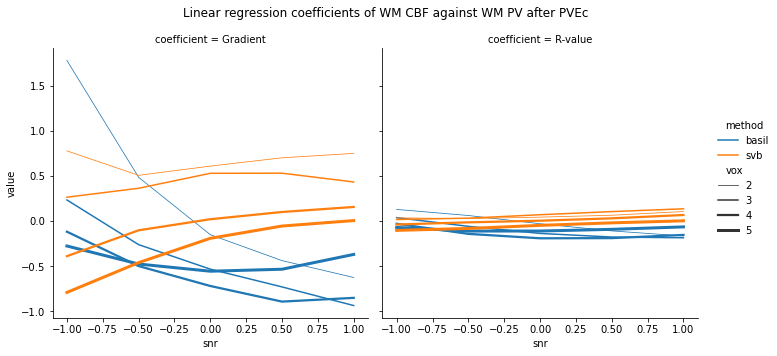

In [64]:
g = sns.relplot(data=pv_regression, x='snr', y='value', hue='method', kind='line', size='vox', col='coefficient')
g.fig.suptitle('Linear regression coefficients of WM CBF against WM PV after PVEc')
g.tight_layout()

## Analysis 10: Subcortical ROI CBF 

Each ROI has been assigned a ground truth CBF value of [45, 50, ..., 75] in increments of 5. SVB infers on ROIs directly. For BASIL, we take the PV mask for the ROI from Toblerone and average GM PVEc CBF within it. 

Note two ROIs (L_Accu and L_Amyg, the first two rows) are by far the smallest, comprising only a few voxels, and so are very challenging to infer on (particularly at 5mm). All the others cover dozens of voxels. Ground truth is denoted in green. 

All in all, there's not a huge difference between the two methods. I think SVB tends to be closer to the ground truth at low SNR, but at higher SNR the differences are pretty marginal. 

In [65]:
subcorts = [] 
    
for v in vox_sizes: 
    proj = projectors[v]
    pvs = proj.pvs()

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:
        odir = f"brain_test/basil_vox-{v}_snr-{snr}_rpt-{RPT}"
        b_cbf = niiload(op.join(odir, 'output_pvcorr/native/perfusion.nii.gz'))
        b_att = niiload(op.join(odir, 'output_pvcorr/native/arrival.nii.gz'))

        for sub in ROI_NAMES: 
            odir = f"brain_test/svb_vox-{v}_snr-{snr}_rpt-{RPT}"
            cbf = niiload(op.join(odir, f'step2/mean_ftiss_{sub}.nii.gz'))
            mask = (cbf > 0)
            att = niiload(op.join(odir, f'step2/mean_delttiss_{sub}.nii.gz')) / TIME_SCALE

            sub = sub.replace('T1_first-', '').replace('_first','')
            subcorts.append({ 'method': 'basil', 'vox': v, 'snr': snr, 'roi': sub, 'cbf': b_cbf[mask].mean(), 'att': b_att[mask].mean() })
            subcorts.append({ 'method': 'svb', 'vox': v, 'snr': snr, 'roi': sub, 'cbf': cbf[mask].mean(), 'att': att[mask].mean() })

subcorts = pd.DataFrame(subcorts).set_index(['method', 'vox', 'snr', 'roi']).reset_index()

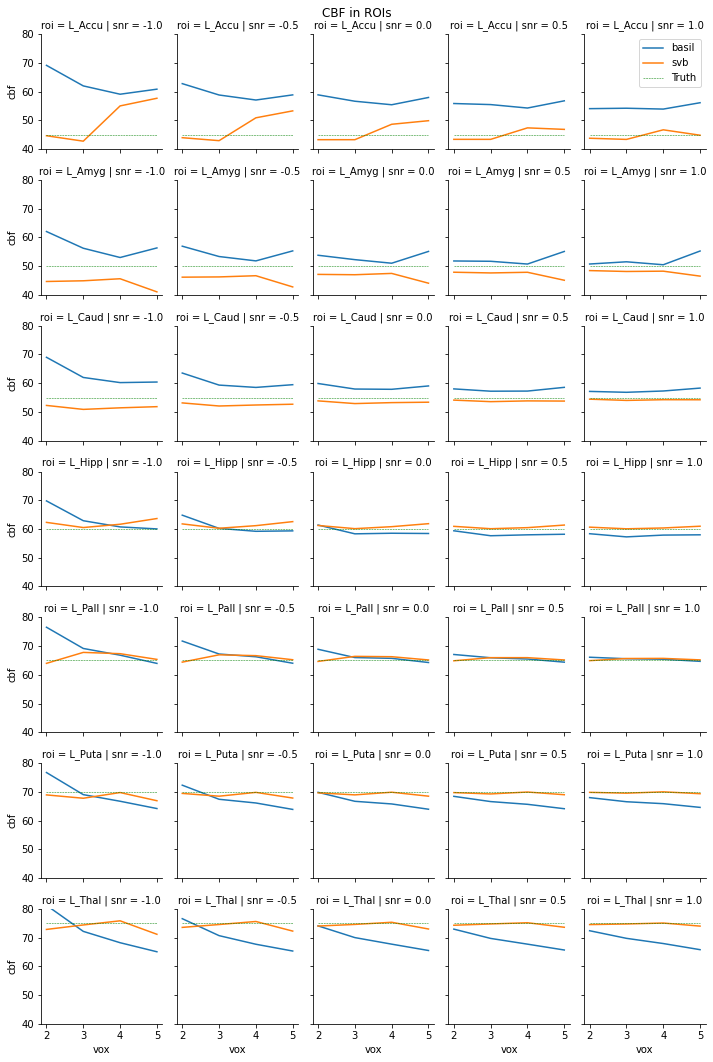

In [66]:
g = sns.FacetGrid(subcorts, row='roi', col='snr')

def mapper(color, data): 
    ax = sns.lineplot(data=data, x='vox', y='cbf', hue='method')
    ax.set_ylim(40,80)

g.map_dataframe(mapper)

for row, val in enumerate([45,50,55,60,65,70,75]): 
    for ax in g.axes[row,:]: 
        ax.plot([subcorts.vox.min(), subcorts.vox.max()], [val,val], 'g--', label='Truth', linewidth=0.5)
g.axes[0,-1].legend()

g.fig.suptitle('CBF in ROIs')
g.fig.set_size_inches(10,15)
g.tight_layout()

## Analysis 11: Subcortical ROI ATT 

Each ROI has the same constant ATT of 1.1s. Recall that BASIL uses a distributional prior of mean value 1.3s whereas SVB uses a spatial prior. 

At low SNR and on the more challenging ROIs (the first two rows), SVB is undoubtedly closer to ground truth than BASIL. At 5mm the first two ROIs barely cover a handful of voxels. 

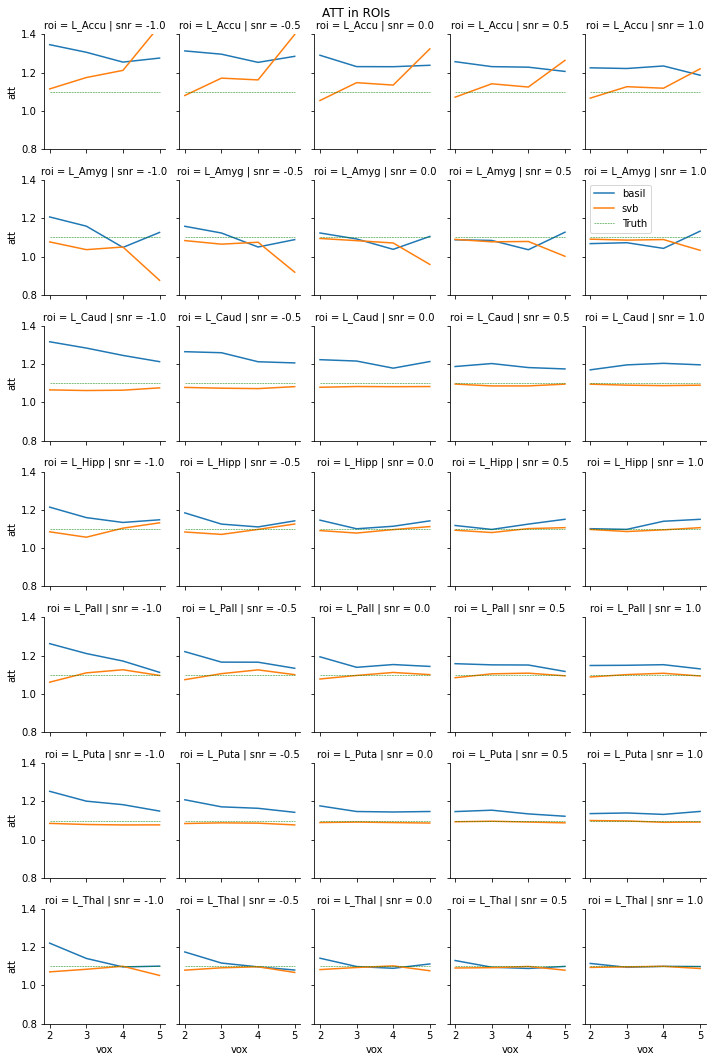

In [67]:
g = sns.FacetGrid(subcorts, row='roi', col='snr')

def mapper(color, data): 
    ax = sns.lineplot(data=data, x='vox', y='att', hue='method')
    ax.plot([data.vox.min(), data.vox.max()], [GM_ATT,GM_ATT], 'g--', label='Truth', linewidth=0.5)
    ax.set_ylim(GM_ATT - 0.3, GM_ATT + 0.3)

g.map_dataframe(mapper)

g.axes[1,-1].legend()
g.fig.suptitle('ATT in ROIs')
g.fig.set_size_inches(10,15)
g.tight_layout()